## 预测波士顿房价-回归问题案例

<p style="text-indent:2em">
**问题描述**：回归问题是机器学习常见的问题，它预测一个连续值而不是离散的标签，例如，根据气象数据预测明天的气温，或者根据软件说明书预测完成软件项目所需要的时间
</p>

注意的地方： logistic 回归不是回归算法，而是分类算法。祥见[logistic 回归](https://baike.baidu.com/item/logistic%E5%9B%9E%E5%BD%92/2981575?fr=aladdin)

### 数据加载

<p style="text-indent:2em">
   本节将要预测 20 世纪 70 年代中期波士顿郊区房屋价格的中位数，已知当时郊区的一些数据点，比如犯罪率、当地房产税率等。  
 </p>
 

&emsp;&emsp;只有 506 个，分为 404 个训练样本和 102 个测试样本。输入数据的每个特征（比如犯罪率）都有不同的取值范围。，有些特性是比例，取值范围为 0~1；有的取值范围为 1~12；还有的取值范围为 0~100，





In [2]:
from keras.datasets import boston_housing

(train_data,train_targets),(test_data,test_targets) \
= boston_housing.load_data("boston_housing.npz")

Using TensorFlow backend.


In [5]:
print(train_data.shape)
print(test_data.shape)
#print(train_targets)

(404, 13)
(102, 13)


### 数据归一化

&emsp;&emsp;由于特征数据的取值范围不同，这样导致网络训练的难度，所以需要对特征数据进行同意的标准化。一般采用的方法：
- 将数据归一化到(0,1),也就是平均值为0，标准差为1。
- 具体做法是：减去平均值，再除以标准差
coding实现如下：


In [3]:
import numpy as np

mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis=0)
train_data/=std

# 测试数据的标准化，也只能使用训练数据的mean,std
test_data -= mean
test_data/=std

### 构建网络

一般来说，训练数据越少，过拟合会越严重，而较小的网络可以降低过拟合。
网络的主体：
   - 两个中间层，每层都有 64 个隐藏单元，使用relu作为激活函数；
   - 第三层输出一个标量，是一个线性层，不需要激活函数这样可以实现任意值的预测。
   
注意的点：
- loss函数：用的是 mse 损失函数，即均方误差（MSE，mean squared error），预测值与目标值之差的平方。这是回归问题常用的损失函数；
- 监控一个新指标：：平均绝对误差（MAE，mean absolute error）。它是预测值与目标值之差的绝对值。
   

In [4]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',
                          input_shape =(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    # 注意没有激活层，是一个线性层，因为回归的是一个标量
    model.add(layers.Dense(1))
    # mse:均方误差
    # mae:平均绝对误差
    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['mae'])
    return model


### 利用`K`折验证法

#### 何时使用K折验证法  

当数据量较小时，验证集的数据也较小，这样到时验证的分数波动很大，也就时方差很大，这样就无法做出有效的评估。

#### 什么时K折验证法

将可用数据划分为 K个分区（K 通常取 4 或 5），实例化 K 个相同的模型，将每个模型在 K-1 个分区上训练，并在剩下的一个分区上进行评估。具体如下图：  

![3折交叉验证](imgs/05.jpg)

在coding使用一个numpy中的函数，也就是数据堆叠。
[concatenate的使用](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.concatenate.html)

每次运行模型得到的验证分数有很大差异，从 2.6 到 3.2 不等。平均分数（3.0）是比单一分数更可靠的指标——这就是 K 折交叉验证的关键。


In [10]:
import numpy as np

# 设定K为4，数据折成4段，也需要循环4次，
k = 4

num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('Processing fold #',i)
    val_data = train_data[i * num_val_samples 
                        : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples 
                        : (i+1) * num_val_samples]
    #数据合成
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i+1) * num_val_samples:]],
        axis = 0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis = 0)
    #创建模型
    model = build_model()
    #开始训练
    model.fit(partial_train_data,
             partial_train_targets,
             epochs = num_epochs,
             batch_size = 1,
             verbose = 0)
    #进行验证
    val_mse,val_mae = model.evaluate(val_data,
                                    val_targets,
                                    verbose=0)
    all_scores.append(val_mae)
    


Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [11]:
print(all_scores)
print("mean scorces:",np.mean(all_scores))

[2.8786396956679843, 3.3748388007135675, 4.058458493487669, 3.562984341441995]
mean scorces: 3.468730332827804


In [5]:
# 500 个轮次并记录模型的数据
import numpy as np

k = 4

num_val_samples = len(train_data) // k
num_epochs = 500
all_scores = []
all_mae_histories = []  

for i in range(k):
    print('Processing fold #',i)
    val_data = train_data[i * num_val_samples 
                        : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples 
                        : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i+1) * num_val_samples:]],
        axis = 0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis = 0)
    model = build_model()
    history = model.fit(partial_train_data,
                 partial_train_targets,
                 validation_data = (val_data,val_targets),
                 epochs = num_epochs,
                 batch_size = 1,
                 verbose = 0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)


Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [8]:
# 计算所有轮次中的 K 折验证分数平均值
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

print(average_mae_history[0])

4.606921585479585


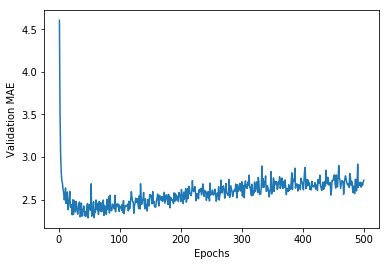

In [10]:
# 绘制验证分数
import matplotlib.pyplot as plt 
 
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history) 
plt.xlabel('Epochs') 
plt.ylabel('Validation MAE') 
plt.show()

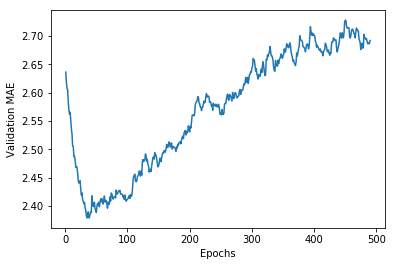

In [11]:
# 　绘制验证分数（删除前 10 个数据点）
def smooth_curve(points, factor=0.9): 
  smoothed_points = [] 
  for point in points: 
    if smoothed_points: 
      previous = smoothed_points[-1] 
      smoothed_points.append(previous * factor + point * (1 - factor)) 
    else: 
      smoothed_points.append(point) 
  return smoothed_points 
 
smooth_mae_history = smooth_curve(average_mae_history[10:]) 
 
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history) 
plt.xlabel('Epochs') 
plt.ylabel('Validation MAE') 
plt.show()

In [15]:
# 训练最终模型
model = build_model()
model.fit(train_data,
         train_targets,
         epochs = 80,
         batch_size = 16,
         verbose = 0)
test_mes_score,test_mae_score = model.evaluate(test_data,
                       test_targets)
print(test_mae_score)

102/102 [==============================] - 0s 1ms/step
2.9683504385106705


### 小结

- 回归问题使用的损失函数与分类问题不同。回归常用的损失函数是均方误差（MSE）。
 - 回归问题使用的评估指标也与分类问题不同。显而易见，精度的概念不适用于回归问题。常见的回归指标是平均绝对误差（MAE）。
 - 如果输入数据的特征具有不同的取值范围，应该先进行预处理，对每个特征单独进行缩放。
 - 如果可用的数据很少，使用 K 折验证可以可靠地评估模型。
 - 如果可用的训练数据很少，最好使用隐藏层较少（通常只有一到两个）的小型网络，以避免严重的过拟合。
